## Dependencies

In [2]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
import matplotlib.pyplot as plt
from calculations.datahandling import*
from calculations.data_processor import* 
from scipy.interpolate import interp1d


## Reading in parameters and topology data

In [3]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

    #Volume-head relationship:
def InputHead(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column], inputdata[head_column]))
    return data_volhead
headvol_Ormset=InputHead('data/Ormset_Data.xlsx')

def InputHead2(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head2')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column].dropna(), inputdata[head_column].dropna()))
    return data_volhead
headvol_Buaset=InputHead2('data/Ormset_Data.xlsx')

    #Flow-head relationship:
def InputFlow(data_file): 
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_headflow'] = inputdata[['Moh','m3/s']].dropna()
    return data_flowhead
headflow=InputFlow('data/Ormset_Data.xlsx')

display(topology)
display(headvol_Ormset)
display(headflow)

def interpolate_head(volume, head_dict):
    volumes = list(head_dict.keys())
    heads = list(head_dict.values())
    return np.interp(volume, volumes, heads)

test=interpolate_head(45, headvol_Ormset)
print(test)

start = '2018-01-01 00:00:00'
end = '2018-01-01 23:00:00'

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN


{'ormset': Ormsetfoss  Pmin  Pmax  Vmax  Vmin  Vstart  Qmin  Qmax  Pump_min  Pump_max  \
 Hydro1       0.0  43.0  45.0   0.0    45.0   0.0  12.0       0.0       0.0   
 Hydro2       0.0  30.0  20.0   0.0    20.0   0.0  12.0       0.0       1.6   
 
 Ormsetfoss    Q    LRL    HRL  RL_start  
 Hydro1      4.0  375.0  389.0     389.0  
 Hydro2      2.0  326.0  331.5     331.5  }

{0.0: 375.0,
 2.08333: 375.99242,
 4.16667: 376.83333,
 6.25: 377.63462,
 8.33333: 378.40476,
 10.41667: 379.09314,
 12.5: 379.70588,
 14.58333: 380.30093,
 16.66667: 380.87963,
 18.75: 381.45833,
 20.83333: 382.03509,
 22.91667: 382.58333,
 25.0: 383.13158,
 27.08333: 383.67982,
 29.16667: 384.22807,
 31.25: 384.77632,
 33.33333: 385.32456,
 35.41667: 385.85417,
 37.5: 386.35714,
 39.58333: 386.85317,
 41.66667: 387.33333,
 43.75: 387.79348,
 45.83333: 388.24638,
 47.91667: 388.65278,
 50.0: 389.0}

{'ormset_headflow':      Moh  m3/s
 0  388.0   0.0
 1  388.2   4.9
 2  388.5  20.4
 3  389.0  68.4}

388.0652204347847


## SDP algorithm 

In [50]:
#Definitions
start = '2018-01-01 00:00:00'
end = '2018-01-01 12:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': 1000, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/2, 'Avg': 1/4, 'Low': 1/4}}

# Create a ConcreteModel
model = pyo.ConcreteModel(name="SDP")

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

# Define the inflow scenarios and associated probabilities
model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])

# Sets to model hydro topology
hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour
model.periods = pyo.Set(initialize=range(1, int(hours_difference) + 1, 1))
#model.periods = pyo.Set(initialize=range(1, 25, 1))                   #these sets must be defined in the latex report as well
model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
model.market = pyo.Set(initialize=['DAM','Sell'])


# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
model.eff = pyo.Param(initialize=constants['eff'])
model.rho = pyo.Param(initialize=constants['rho'])
model.g = pyo.Param(initialize=constants['g'])

# Cost parameters
#max_purchase_limit = 100  # Adjust this value as needed                #Buy-in market price (initial market price cost)
#model.PurchaseLimit = pyo.Param(initialize=max_purchase_limit)
model.Mi = pyo.Param(model.periods, initialize=market_prices_h)            #Market price varying
model.Ri=pyo.Param(model.periods, initialize=constants['Ri'])  #Rationing cost for plants
model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

#Plant parameters
model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

#Load parameters
model.L = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})

#Topology parameters
model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
model.inflow = pyo.Var(model.plants, model.periods, model.scenarios, within=NonNegativeReals)


#Scenario parameter
model.probs=pyo.Param(model.scenarios, initialize=constants['inflow_probabilities'])


# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j, s):
    return (model.Pmin[i], model.Pmax[i])
model.p = pyo.Var(model.plants, model.periods, model.scenarios,  bounds=p_bounds)                   #Power production
model.m = pyo.Var(model.market, model.periods, model.scenarios, within=NonNegativeReals)       #Power bougth from lack of production

def q_bounds(model, i, j, s): #flow rate
    return (model.Qmin[i], model.Qmax[i])
model.q = pyo.Var(model.plants, model.periods, model.scenarios,  bounds=q_bounds)
model.q_out=pyo.Var(model.plants, model.periods, model.scenarios,  within=NonNegativeReals)

def pump_bounds(model, i, j, s):
    return(model.Pump_min[i], model.Pump_max[i])
model.pump=pyo.Var(model.plants, model.periods, model.scenarios, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)

def vol_bounds(model, i, j, s):
    return (model.Vmin[i], model.Vmax[i])
def init_v(model, i, j, s):
    return model.v0[i]
model.v = pyo.Var(model.plants, model.periods, model.scenarios, bounds=vol_bounds, initialize=init_v) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)

def head_bounds(model,i,j,s):
    return (model.LRL[i], model.HRL[i])
model.h = pyo.Var(model.plants, model.periods, model.scenarios,  bounds=head_bounds)

model.r=pyo.Var(model.plants, model.periods, model.scenarios, within=NonNegativeReals) #amount rationed for each plant (should have bounds)
model.s=pyo.Var(model.plants, model.periods, model.scenarios, within=NonNegativeReals) #amount spilled for each reservoir (should have bounds)

#initializing scenarios for inflow

def inflow1_scenario(model, i, j, s):
    if i=='Hydro1':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro1, 0.5)[j]
    elif i == 'Hydro2':
        if s == 'High': 
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1.5)[j]
        elif s == 'Avg':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 1)[j]
        elif s == 'Low':
            return model.inflow[i,j,s]==scale_dict(inflow_hydro2, 0.5)[j]
model.inflow_cons=pyo.Constraint(model.plants, model.periods, model.scenarios, rule=inflow1_scenario)
        
#-------------------MODEL OF RESERVOIRS------------------#
model.cumulative_q = pyo.Var(model.plants, model.periods, model.scenarios,  within=pyo.NonNegativeReals)
model.cumulative_inflow = pyo.Var(model.plants, model.periods, model.scenarios, within=pyo.NonNegativeReals)#combining discharge (q [m3/s]) into m3 over given timeframe (NEED TO CHECK CONVERSIONS)
model.cumulative_pump = pyo.Var(model.plants, model.periods, model.scenarios, within=pyo.NonNegativeReals)
# Constraint to calculate the cumulative sum of discharges (WATER OUT OF PLANTS)

def cumulative_pump_rule(model, i, j, s):
    if j == 1:
        if i == 'Hydro1':
            return model.cumulative_pump[i, j, s] == 0
        elif i == 'Hydro2':
            return model.cumulative_pump[i,j, s] == model.pump[i,j, s]
    else:
        if i =='Hydro1':
            return model.cumulative_pump[i, j, s]  == 0
        elif i =='Hydro2':
            return model.cumulative_pump[i, j, s]  == model.cumulative_pump[i, j - 1, s] + model.pump[i,j, s]
model.cumulative_pump_cons = pyo.Constraint(model.plants, model.periods, model.scenarios, rule=cumulative_pump_rule)

def cumulative_q_rule(model, i, j, s):
    if j == 1:
        if i == 'Hydro1':
            return model.cumulative_q[i, j, s] == model.q[i, j, s] 
        elif i == 'Hydro2':
          return model.cumulative_q[i,j, s] == model.q[i,j, s] 
    else:
        if i =='Hydro1':
            return model.cumulative_q[i, j, s]  == model.cumulative_q[i, j - 1, s] + model.q[i, j, s]
        elif i =='Hydro2':
            return model.cumulative_q[i, j, s]  == model.cumulative_q[i, j - 1, s] + model.q[i, j, s] 
model.cumulative_q_cons = pyo.Constraint(model.plants, model.periods, model.scenarios,  rule=cumulative_q_rule)

def cumulative_inflow_rule(model, i, j, s):
    if j == 1:
        if i == 'Hydro1':
            return model.cumulative_inflow[i, j, s] == model.inflow[i, j, s] 
        else:  # Hydro2
            return model.cumulative_inflow[i, j, s] == model.inflow[i, j, s] 
    else:
        if i == 'Hydro1':
            return model.cumulative_inflow[i, j, s] == model.cumulative_inflow[i, j - 1, s] + model.inflow[i, j, s]
        else:  # Hydro2
            return model.cumulative_inflow[i, j, s] == model.cumulative_inflow[i, j - 1, s] + model.inflow[i, j, s]

model.cumulative_inflow_cons = pyo.Constraint(model.plants, model.periods, model.scenarios,  rule=cumulative_inflow_rule)


# Constraints
def load_rule(model, j, s):
    return model.p['Hydro1',j, s] + model.p['Hydro2',j, s] + model.m['DAM',j, s] == model.L[j] - (model.r['Hydro1',j, s] + model.r['Hydro2', j, s]) + model.m['Sell',j, s]
model.load_cons = pyo.Constraint(model.periods, model.scenarios, rule=load_rule)


def power_rule(model,i,j, s):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.h[i,j, s] * model.q[i, j, s] == model.p[i, j, s]#MW
model.power_prod = pyo.Constraint(model.plants, model.periods, model.scenarios, rule=power_rule)

def vol_rule(model, i, s):
    tolerance = 1e2  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, max(model.periods), s] >= model.v0[i] - tolerance
model.volume_end = pyo.Constraint(model.plants, model.scenarios,  rule=vol_rule)

#def open_rule(model,i, j):
#    return model.v[i, j] <= model.Vmax_reg[i] - (1 - model.gate_var[j])
#model.gate_open = pyo.Constraint(model.plants, model.periods, rule=open_rule)

#def close_rule(model,i, j):
#    return model.v[i, j] >= model.Vmin_reg[i] + model.gate_var[j]
#model.gate_close = pyo.Constraint(model.plants, model.periods, rule=close_rule)

    
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
def volume_change_rule(model, i, j, s):
    if j==1:
        if i == 'Hydro1':
            return model.v[i, j , s] == (model.v0[i]) - (model.q[i, j, s] *fm3) + (model.inflow[i, j, s]*fm3) +(model.pump['Hydro2',j, s]*fm3) 
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j, s] == (model.v0[i]) - (model.q[i, j, s] *fm3) + (model.inflow[i, j, s]*fm3) + (model.q_out['Hydro1', j, s]*fm3) 
    
    else:
        if i == 'Hydro1':
            return model.v[i, j , s] == (model.v[i,j-1,s]) - (model.q[i, j, s] *fm3) + (model.inflow[i, j, s]*fm3) +(model.pump['Hydro2',j, s]*fm3) 
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j, s] == (model.v[i,j-1,s]) - (model.q[i, j, s] *fm3) + (model.inflow[i, j, s]*fm3) + (model.q_out['Hydro1', j, s]*fm3) 
    
model.volume_change_cons = pyo.Constraint(model.plants, model.periods, model.scenarios, rule=volume_change_rule)


# Solve the model
opt = pyo.SolverFactory('gurobi', solver_io="python")
opt.options['NonConvex'] = 2  # Set NonConvex parameter to 2 




# Step a) Define system states for each stage as a percentage of v0
states_percentages = list(range(100, -1, -4)) # States as percentages
M = len(states_percentages)  # Number of storage levels

# solving one-stage problem and initializing reservoir levels
def solve_one_stage(model , j, s, i, future):
    last_stage=max(model.periods)
    model.v['Hydro1',j,s].fix(value(model.v0['Hydro1'])*(states_percentages[i]/100)-(model.q['Hydro1', j, s] *fm3) + (model.inflow['Hydro1', j, s]*fm3) +(model.pump['Hydro2',j, s]*fm3) )
    model.v['Hydro2',j,s].fix(value(model.v0['Hydro2'])*(states_percentages[i]/100)- (model.q['Hydro2', j, s] *fm3) + (model.inflow['Hydro2', j, s]*fm3) + (model.q_out['Hydro1', j, s]*fm3) )
    if j==last_stage:
        future_cost=0
        return model.probs[s]* (model.Ri[j]*(model.r['Hydro1',j,s] + model.r['Hydro2',j,s]) + model.Mi[j]*(model.m['DAM',j,s]))
    elif j>= min(model.periods)-1:
        future_cost=future[i-1]
        return model.probs[s]* (model.Ri[j]*(model.r['Hydro1',j,s] + model.r['Hydro2',j,s]) + model.Mi[j]*(model.m['DAM',j,s]) + future_cost)

    


    
#calculating expected costs as mean of the inflow scenario's objective value
def calculate_exp_cost(model, j, exp):
    expected=exp/len(model.scenarios)
    return expected




# Creating future cost function through interpolation between current and prevois value
def create_future_cost(costs_list):
    future_cost=[]
    for index in range(len(states_percentages)):
        if index==0:
            FC=costs_list[0]
            future_cost.append(FC)
        else: 
            FC= (costs_list[index]+future_cost[index-1])/2
            future_cost.append(FC)
        return future_cost

#Solve last stage T problem to obtain FCF for T-1
def initialize_last_stage(model):
    costs=[]
    for i in range(len(states_percentages)):  
        obj_init=0 
        for s in model.scenarios:
            solve_init=solve_one_stage(model, max(model.periods), s, i, 0)        #Solving with future value=0
            model.obj=pyo.Objective(rule=solve_init, sense=pyo.minimize)
            results = opt.solve(model, tee=True)
            obj_init+=pyo.value(model.obj)                                              #Adding the objective value of each scenario
            
        exp_cost_init=calculate_exp_cost(model, max(model.periods), obj_init)   #Calling function for calculating mean
        costs.append(exp_cost_init)                                             #appending to list over expected costs
                                        #iterating for all  indexes in state variable
    initial_FCF=create_future_cost(costs)            #creating future cost values for each state                                     #appending fc values to list 
    return initial_FCF
            
    
    

def SDP_recursion(model):
    future_cost=initialize_last_stage(model)                                    #Initializing the future cost list from last stage
    for stage in range(max(model.periods)-1, min(model.periods)-1, -1):         #Iterating from T-1-->0
        costs=[]                                                                #Creating new expected cost list for each stage
        for i in range(len(states_percentages)): 
            obj=0   
            for s in model.scenarios:
                #solve one stage problem 
                solve=solve_one_stage(model, stage, s, i, future_cost)          #Solving now with future cost based on the previously calculated function
                model.obj=pyo.Objective(rule=solve, sense=pyo.minimize)              
                results = opt.solve(model, tee=True)
                obj+=pyo.value(model.obj)                                             #Adding for each scenario
            #Calculate the expected operation cost of discrete state 
            exp_cost=calculate_exp_cost(model, stage, obj)                      #Calculating new expexted cost for each state 
            costs.append(exp_cost)                                              #new list for new stage
        #Construct future cost function of state in current stage
                                                       
        future_cost=create_future_cost(costs)                  #future cost list is updated with new values for each state in each stage
    results = opt.solve(model, tee=True)
    return future_cost

SDP_recursion(model)

# Display the results
print("Optimal operation cost:", model.obj())
print("\nDual values:")
for c in model.component_objects(Constraint, active=True):
    print("Constraint", c)
    c.display()

    
results = opt.solve(model, tee=True)
model.display()



# Check if the solution is optimal and plot the optimal power production 
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    for s in model.scenarios:
        power_production = {(plant, period, s): model.p[plant, period, s].value for plant in model.plants for period in model.periods}
        market_power = {(market, period, s): model.m[market, period, s].value for market in model.market for period in model.periods}
        #market_sell = {(market, period): model.m[market, period].value for market in model.market for period in model.periods}
        ration_power= {(plant, period, s): model.r[plant, period, s].value for plant in model.plants for period in model.periods}
        load_values = [model.L[j] for j in model.periods]
        colors = ['b', 'g', 'c']  # Add 'c' for the market

        fig, ax1 = plt.subplots()
        ax1.plot(model.periods, load_values, 'r-', label='Load')
        ax1.set_xlabel('Periods [h]')
        ax1.set_ylabel('Load [MW]', color='r')
        ax1.tick_params('y', colors='r')
        ax2 = ax1.twinx()
        ax1.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed
        ax2.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed


        bottom = np.zeros(len(model.periods))  # Initialize the bottom position for stacking

        for i, plant in enumerate(model.plants):
            power_values = [power_production[plant, period, s] for period in model.periods]
            ax2.bar(model.periods, power_values, color=colors[i], alpha=0.5, label=f'{plant}, Inflow: {s}, Power Production', bottom=bottom)
            bottom += power_values  # Update the bottom position for the next set of bars

        market_power_values = [market_power['DAM', period, s] for period in model.periods]
        ax2.bar(model.periods, market_power_values, color='c', alpha=0.5, label='Power bought from market', bottom=bottom)

        # Add bars for market_sell_values
        market_sell_values = [market_power['Sell', period, s] for period in model.periods]
        ax2.bar(model.periods, market_sell_values, color='m', alpha=0.5, label='Power sold to market', bottom=bottom)
        
        for i, plant in enumerate(model.plants):
            ration_values = [ration_power[plant, period, s] for period in model.periods]
            ax2.bar(model.periods, ration_values,  alpha=0.5, label=f'{plant}, Inflow: {s},  Rationed Power', bottom=bottom)
            bottom += ration_values  # Update the bottom position for the next set of bars

        

        ax2.set_ylabel('Power [MW]', color='b')
        ax2.tick_params('y', colors='b')
        ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
        ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))
        plt.title('Power produced and bought vs Load')
        plt.show()
        print("Objective Value:", model.obj())
else: 
    log_infeasible_constraints(model)
    print("Solver did not find an optimal solution.")
model.display()


# Display the model specifics
print()
model.pprint()
print()
#model.constraint.pprint()
print()
model.obj.display()
print()

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 798 rows, 1872 columns and 2433 nonzeros
Model fingerprint: 0xe56e9f2d
Model has 144 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  QMatrix range    [9e-03, 9e-03]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+01, 5e+02]
  Bounds range     [2e+00, 4e+02]
  RHS range        [4e-02, 8e+01]
Presolve removed 662 rows and 1238 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 775 rows and 1759 columns
Presolve time: 0.01s
Presolved: 115 rows, 113 columns, 321 nonzeros
Presolved model has 23 bilinear constraint(s)
Variable types: 113 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 38 iterations, 0.00 seconds (0.00 work u

IndexError: list index out of range

## Plotting of variables

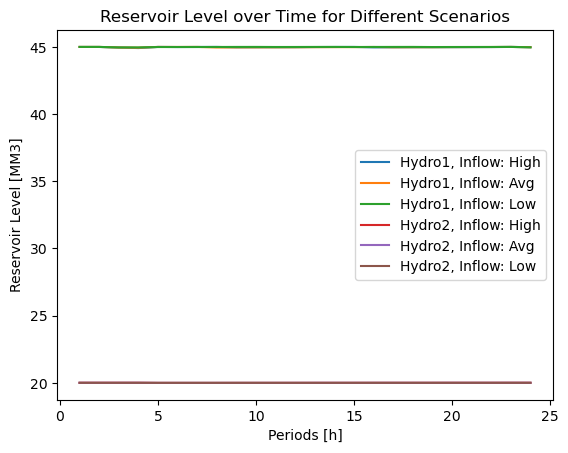

In [51]:
# Function to extract reservoir levels for plotting
def extract_reservoir_levels(model, reservoir, scenario):
    reservoir_levels = [model.v[reservoir, period, scenario].value for period in model.periods]
    return reservoir_levels

# Reservoirs and scenarios to plot
reservoirs_to_plot = ['Hydro1', 'Hydro2']
scenarios_to_plot = model.scenarios

# Plot reservoir levels
for reservoir in reservoirs_to_plot:
    for scenario in scenarios_to_plot:
        reservoir_levels = extract_reservoir_levels(model, reservoir, scenario)
        plt.plot(model.periods, reservoir_levels, label=f'{reservoir}, Inflow: {scenario}')

plt.xlabel('Periods [h]')
plt.ylabel('Reservoir Level [MM3]')
plt.legend()
plt.title('Reservoir Level over Time for Different Scenarios')
plt.show()


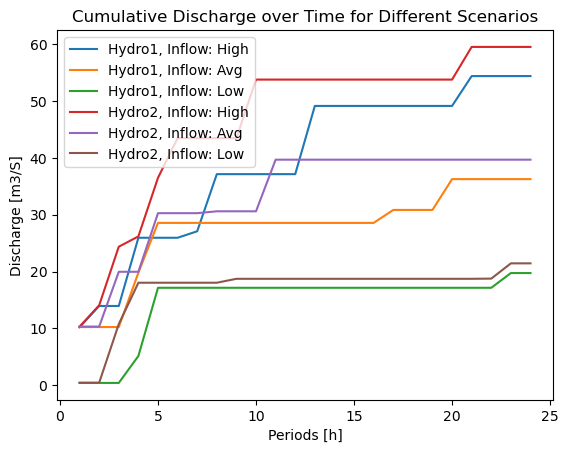

In [22]:
# Function to extract reservoir levels for plotting
def extract_reservoir_levels(model, reservoir, scenario):
    reservoir_levels = [model.cumulative_q[reservoir, period, scenario].value for period in model.periods]
    return reservoir_levels

# Reservoirs and scenarios to plot
reservoirs_to_plot = ['Hydro1', 'Hydro2']
scenarios_to_plot = model.scenarios

# Plot reservoir levels
for reservoir in reservoirs_to_plot:
    for scenario in scenarios_to_plot:
        reservoir_levels = extract_reservoir_levels(model, reservoir, scenario)
        plt.plot(model.periods, reservoir_levels, label=f'{reservoir}, Inflow: {scenario}')

plt.xlabel('Periods [h]')
plt.ylabel('Discharge [m3/S]')
plt.legend()
plt.title('Cumulative Discharge over Time for Different Scenarios')
plt.show()

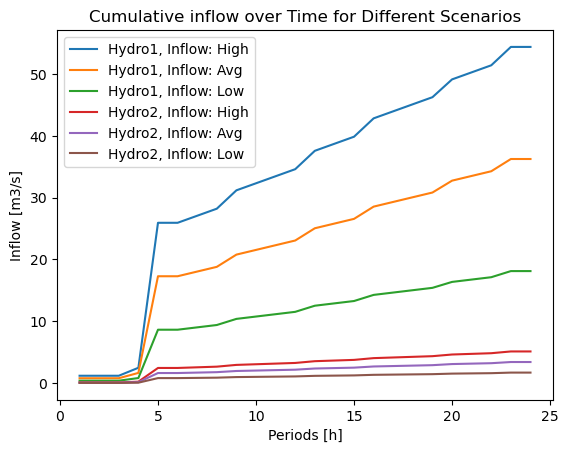

In [ ]:
# Function to extract reservoir levels for plotting
def extract_reservoir_levels(model, reservoir, scenario):
    reservoir_levels = [model.cumulative_inflow[reservoir, period, scenario].value for period in model.periods]
    return reservoir_levels

# Reservoirs and scenarios to plot
reservoirs_to_plot = ['Hydro1', 'Hydro2']
scenarios_to_plot = model.scenarios

# Plot reservoir levels
for reservoir in reservoirs_to_plot:
    for scenario in scenarios_to_plot:
        reservoir_levels = extract_reservoir_levels(model, reservoir, scenario)
        plt.plot(model.periods, reservoir_levels, label=f'{reservoir}, Inflow: {scenario}')

plt.xlabel('Periods [h]')
plt.ylabel('Inflow [m3/s]')
plt.legend()
plt.title('Cumulative inflow over Time for Different Scenarios')
plt.show()

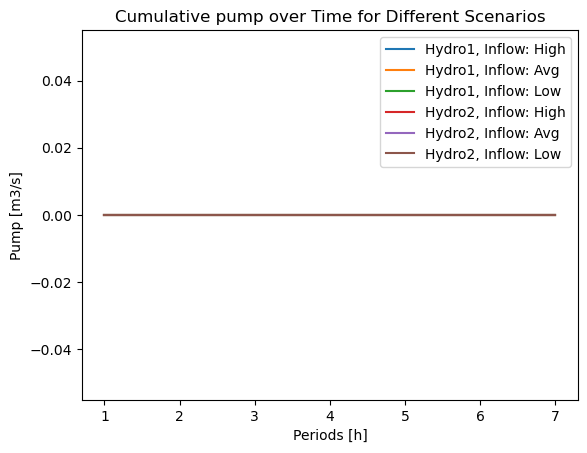

In [ ]:
# Function to extract reservoir levels for plotting
def extract_reservoir_levels(model, reservoir, scenario):
    reservoir_levels = [model.cumulative_pump[reservoir, period, scenario].value for period in model.periods]
    return reservoir_levels

# Reservoirs and scenarios to plot
reservoirs_to_plot = ['Hydro1', 'Hydro2']
scenarios_to_plot = model.scenarios

# Plot reservoir levels
for reservoir in reservoirs_to_plot:
    for scenario in scenarios_to_plot:
        reservoir_levels = extract_reservoir_levels(model, reservoir, scenario)
        plt.plot(model.periods, reservoir_levels, label=f'{reservoir}, Inflow: {scenario}')

plt.xlabel('Periods [h]')
plt.ylabel('Pump [m3/s]')
plt.legend()
plt.title('Cumulative pump over Time for Different Scenarios')
plt.show()

In [ ]:
# Step a) Define system states for each stage as a percentage of v0
states_percentages = list(range(100, -1, -2)) # States as percentages
M = len(states_percentages)  # Number of storage levels





# Step a) Define system states for each stage as a percentage of v0
states_percentages = list(range(100, -1, -2)) # States as percentages
M = len(states_percentages)  # Number of storage levels


def solve_one_stage_last_stage(model, scenario, percentage):
    last_stage = max(model.periods)
    for s in scenario:
        model.v['Hydro1', last_stage, s]==model.v0['Hydro1']*(percentage/100)  # Set the reservoir level based on the percentage
        model.v['Hydro2', last_stage, s]==model.v0['Hydro2']*(percentage/100) # Set the reservoir level based on the percentage
        model.obj.expr = sum(model.probs[s]* (model.Ri[j]*model.r[i,j,s] + model.Mi[j]*(model.m['DAM',j,s])) for i in model.plants for j in [last_stage])
    results=opt.solve(model)
    return model.obj()



# Step c) Calculate expected operation cost for each state in stage J-1, J-2, ...
def calculate_expected_operation_cost(model, stage, s):
    cost_list = []
    for percentage in states_percentages:
        expected_cost = solve_one_stage_last_stage(model, s, percentage)
    for s in model.scenarios:
        exp_avg=sum(expected_cost)/len(s)
        cost_list.append(exp_avg)
    return cost_list



# Step d) Update the objective function for previous stages to minimize the immediate operation cost
def update_objective_function(model, j, s, interpolated_costs):
    expected_future_cost = interpolated_costs[states_percentages.index(100)]  # Expected future cost for 100% storage
    immediate_cost = sum(model.probs[s]* (model.Ri[j]*model.r[i,j,s] + model.Mi[j]*(model.m['DAM',j,s])) for i in model.plants)  # Immediate operation cost in stage J-1
    model.obj.expr = immediate_cost + expected_future_cost



# Interpolation of costs between calculated stages
def interpolate_costs(costs):
    # Simple linear interpolation for demonstration purposes
    interpolated_costs = [(costs[i] + costs[i + 1]) / 2 for i in range(len(costs) - 1)]
    return interpolated_costs

# Iterate through stages J-1, J-2, ... and update the objective function
interpolated_costs = interpolate_costs(calculate_expected_operation_cost(model, max(model.periods), model.scenarios))
for stage in range(max(model.periods) - 1, min(model.periods), -1):
    for s in model.scenarios:
        update_objective_function(model, stage, s, interpolated_costs)


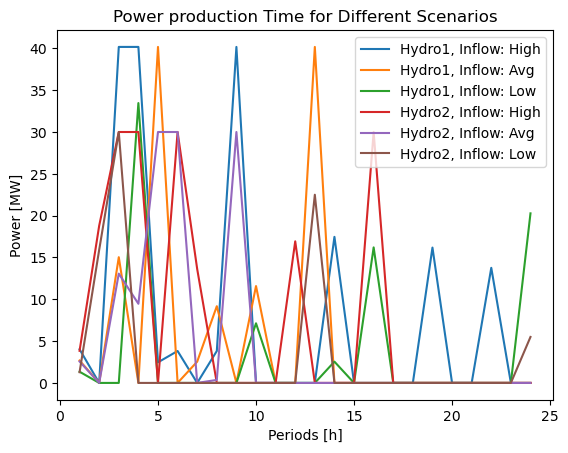

In [ ]:
def extract_reservoir_levels(model, reservoir, scenario):
    reservoir_levels = [model.p[reservoir, period, scenario].value for period in model.periods]
    return reservoir_levels

# Reservoirs and scenarios to plot
reservoirs_to_plot = ['Hydro1', 'Hydro2']
scenarios_to_plot = model.scenarios

# Plot reservoir levels
for reservoir in reservoirs_to_plot:
    for scenario in scenarios_to_plot:
        reservoir_levels = extract_reservoir_levels(model, reservoir, scenario)
        plt.plot(model.periods, reservoir_levels, label=f'{reservoir}, Inflow: {scenario}')

plt.xlabel('Periods [h]')
plt.ylabel('Power [MW]')
plt.legend()
plt.title('Power production Time for Different Scenarios')
plt.show()